## Convolutional Neural Network


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from math import sqrt
from sklearn.decomposition import PCA

### CNN data pre-processing

In [9]:
## load pre-processed data used earlier for XGB
df_energy_weather_proc = pd.read_csv(
    "input data/energy_weather_table_proc.csv",
    parse_dates=['dt_iso']
)

# parse date-time and set as index
df_energy_weather_proc['dt_iso'] = pd.to_datetime(df_energy_weather_proc['dt_iso'], utc=True, infer_datetime_format=True)
df_energy_weather_proc = df_energy_weather_proc.set_index('dt_iso')

## sort the dataset for use in the modeling
## we will use pre-2018 data as training and validation
## the data from 2018 will be used as the test dataset
df_energy_weather_proc = df_energy_weather_proc.sort_index()


In [10]:
## Helper functions
## Reference code from https://www.kaggle.com/electricity-price-forecasting-with-dnns-eda#3.-Feature-Engineering
def multivariate_data(input_df, target_col, start_idx, end_idx, history_window,
                      target_window):
    step=1
    single_step=True
    data, labels = [], []

    start_idx = start_idx + history_window
    if end_idx is None:
        end_idx = len(input_df) - target_window

    for i in range(start_idx, end_idx):
        indices = range(i-history_window, i, step)
        data.append(input_df[indices])

        if single_step:
            labels.append(target_col[i + target_window])
        else:
            labels.append(target_col[i : i + target_window])

    return np.array(data), np.array(labels)

In [11]:
def plot_model_rmse_and_loss(history, model_name):

    # Evaluate train and validation accuracies and losses
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_rmse = history.history['root_mean_squared_error']
    validation_rmse = history.history['val_root_mean_squared_error']

    # Visualize epochs vs. train and validation accuracies and losses
    plt.figure(figsize=(25, 15))
    plt.subplot(1, 2, 1)
    plt.plot(training_rmse, label='Training RMSE')
    plt.plot(validation_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Iterations vs. Training and Validation RMSE for ' + model_name)

    plt.subplot(1, 2, 2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss for ' + model_name)

    plt.show()

### Make the predictions for price, load, solar and wind output

In [12]:
# main function for prediction and output model performance
# actual_column = the target column to predict
# model_name = the name of our model, it will be used to save the model performance
def predict_df(actual_column, model_name):

    # prepare out dataset, drop the target columns from X
    # sae them to the Y array
    X = df_energy_weather_proc.drop(columns=[actual_column])
    y = df_energy_weather_proc[actual_column].values
    y = y.reshape(-1,1)

    # split dataset
    train_end_idx = 17545 # use years 2014-16 for training
    cv_end_idx = 26305 # user year 2017 for validation
    test_end_idx = 35064 # use year 2018 for testing

    # scale data
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    scaler_X.fit(X[:train_end_idx])
    scaler_y.fit(y[:train_end_idx])

    X_norm = scaler_X.transform(X)
    y_norm = scaler_y.transform(y)

    # PCA
    pca = PCA()
    # X_pca = pca.fit(X_norm[:train_end_idx])

    pca = PCA(n_components=0.80)
    pca.fit(X_norm[:train_end_idx])

    X_pca = pca.transform(X_norm)
    X_pca.shape

    # Norm
    dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

    past_history, future_target = 24, 0

    X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                         0, train_end_idx, past_history,
                                         future_target)

    X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     train_end_idx, cv_end_idx, past_history,
                                     future_target)

    X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                       cv_end_idx, test_end_idx, past_history,
                                       future_target)

    ## set some CNN parameters
    batch_size = 32
    buffer_size = 1000
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

    validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    validation = validation.batch(batch_size).prefetch(1)

    # Define some common parameters
    input_shape = X_train.shape[-2:]
    loss = tf.keras.losses.MeanSquaredError()
    metric = [tf.keras.metrics.RootMeanSquaredError()]
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                  lambda epoch: 1e-4 * 10**(epoch / 10))
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
    y_test = y_test.reshape(-1, 1)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # CNN modeling
    tf.keras.backend.clear_session()

    multivariate_cnn = tf.keras.models.Sequential([
        Conv1D(filters=48, kernel_size=2,
               strides=1, padding='causal',
               activation='relu',
               input_shape=input_shape),
        Flatten(),
        Dense(48, activation='relu'),
        Dense(1)
    ])

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                       'multivariate_cnn.h5', save_best_only=True)
    optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

    multivariate_cnn.compile(loss=loss,
                              optimizer=optimizer,
                              metrics=metric)

    history = multivariate_cnn.fit(train, epochs=30,
                                   validation_data=validation,
                                   callbacks=[early_stopping,
                                              model_checkpoint])

    multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

    forecast = multivariate_cnn.predict(X_test)
    cnn_forecast = scaler_y.inverse_transform(forecast)

    # scale back the model's performance RMSE and Loss
    for k in history.history.keys():
        val_array = np.array(history.history[k])
        val_array = val_array.reshape(-1, 1)
        val_array = scaler_y.inverse_transform(val_array)
        val_array = val_array.reshape(-1)
        history.history[k] = val_array.tolist()

    plot_model_rmse_and_loss(history, model_name)

    #export model performance
    with open('output data/cnn/' + model_name + '.json', 'w') as fp:
        json.dump(history.history, fp)

    return cnn_forecast

Epoch 1/30
548/548 [==============================] - 3s 4ms/step - loss: 0.3132 - root_mean_squared_error: 0.4911 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316

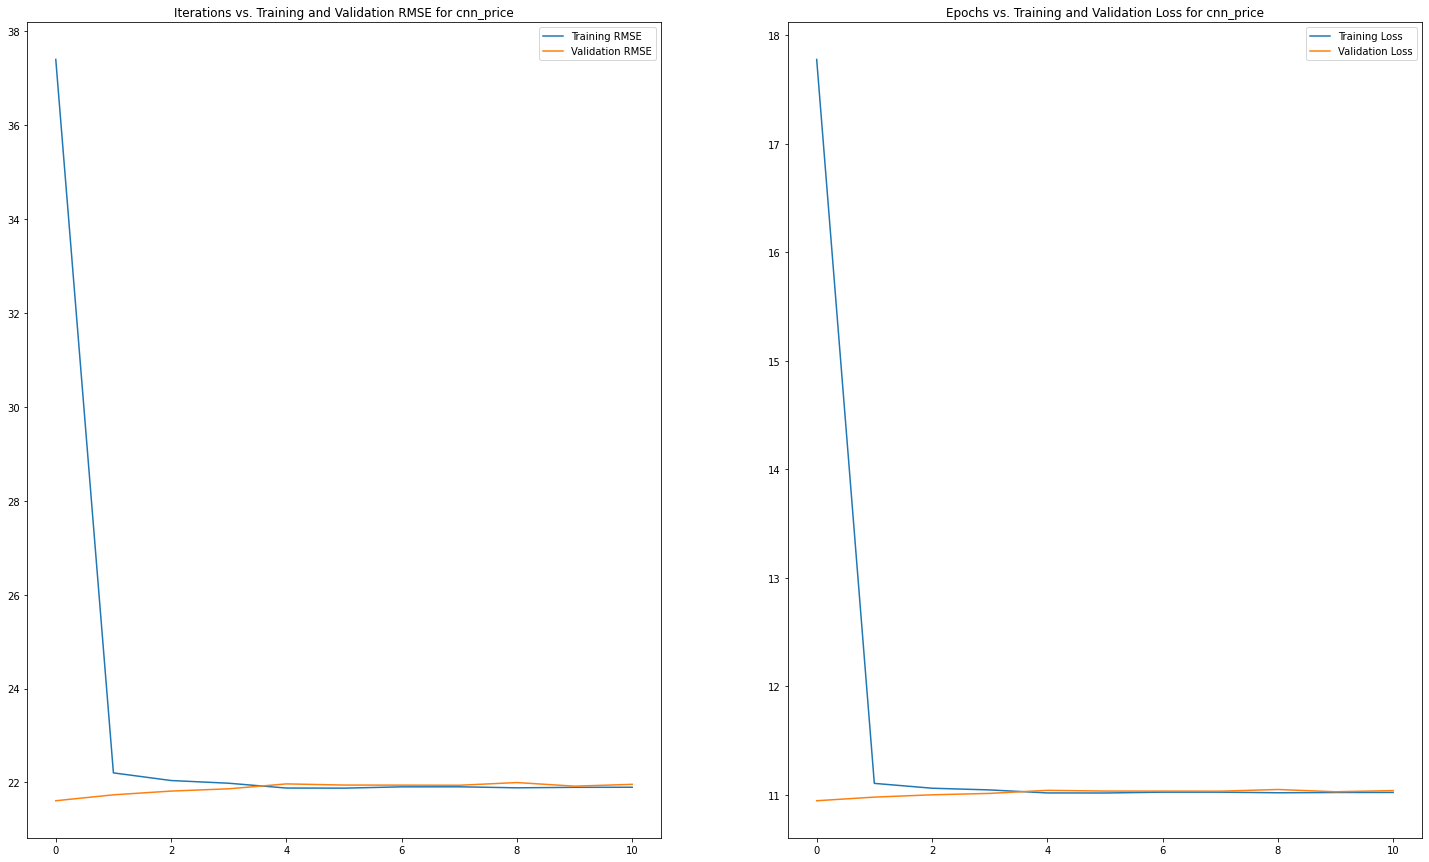

<ipython-input-13-db49f354b247>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy_weather_cnn_preds['price_predicted'] = predict_df('price_actual', 'cnn_price')
<ipython-input-13-db49f354b247>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy_weather_cnn_preds['total_load_predicted'] = predict_df('total_load_actual', 'cnn_load')
<ipython-input-13-db49f354b247>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

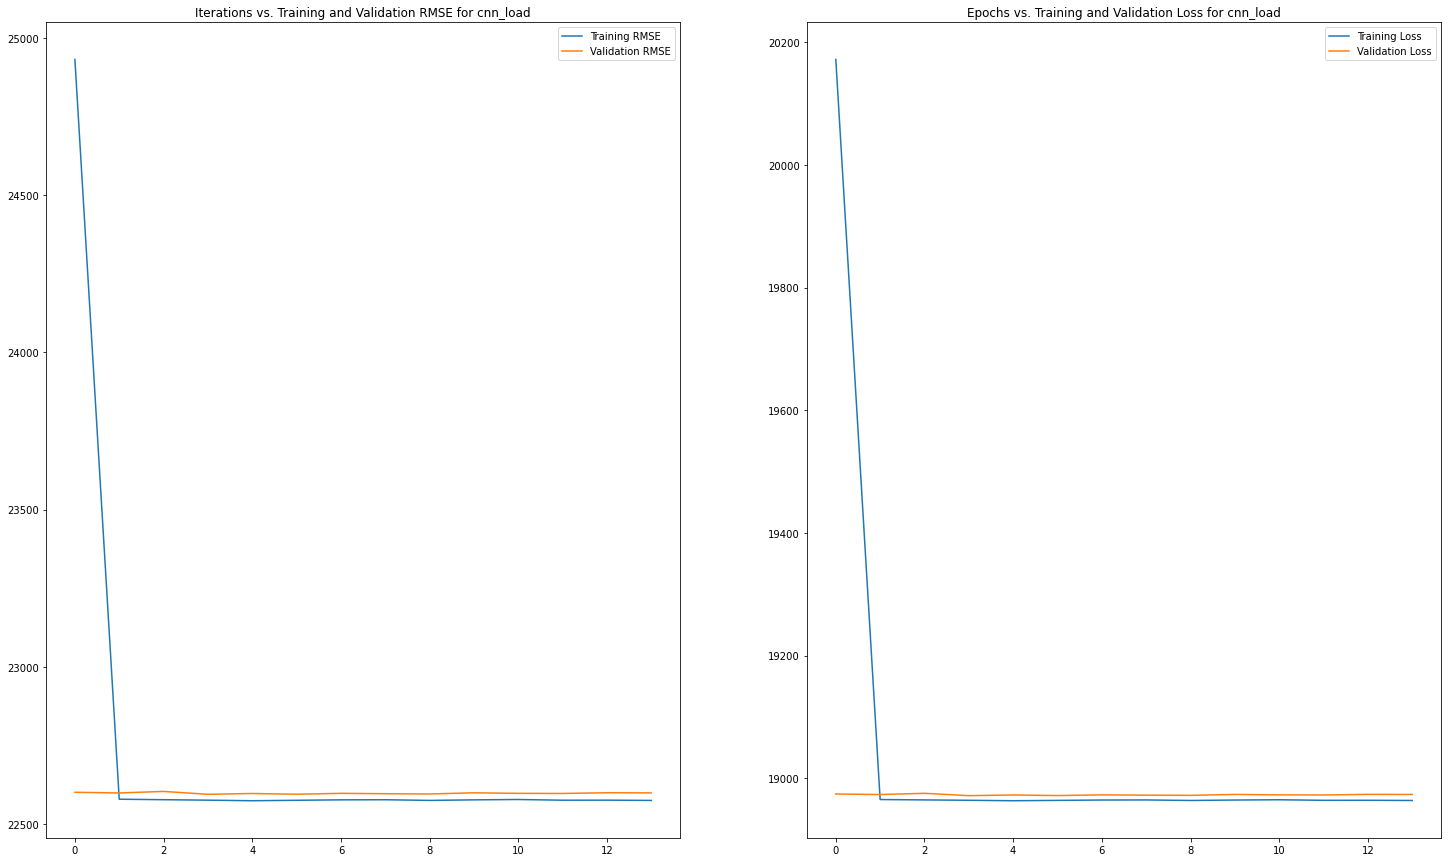

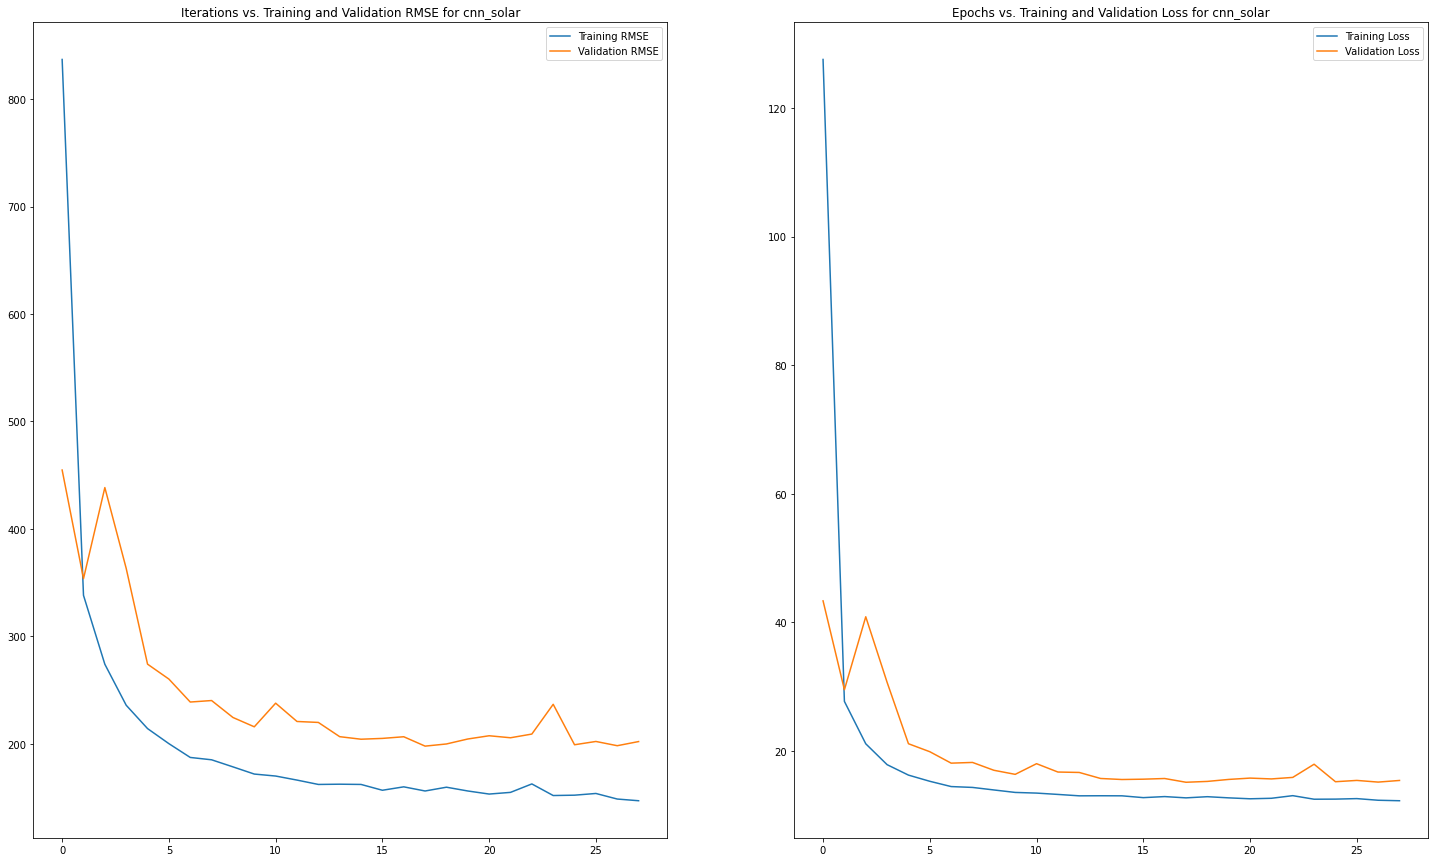

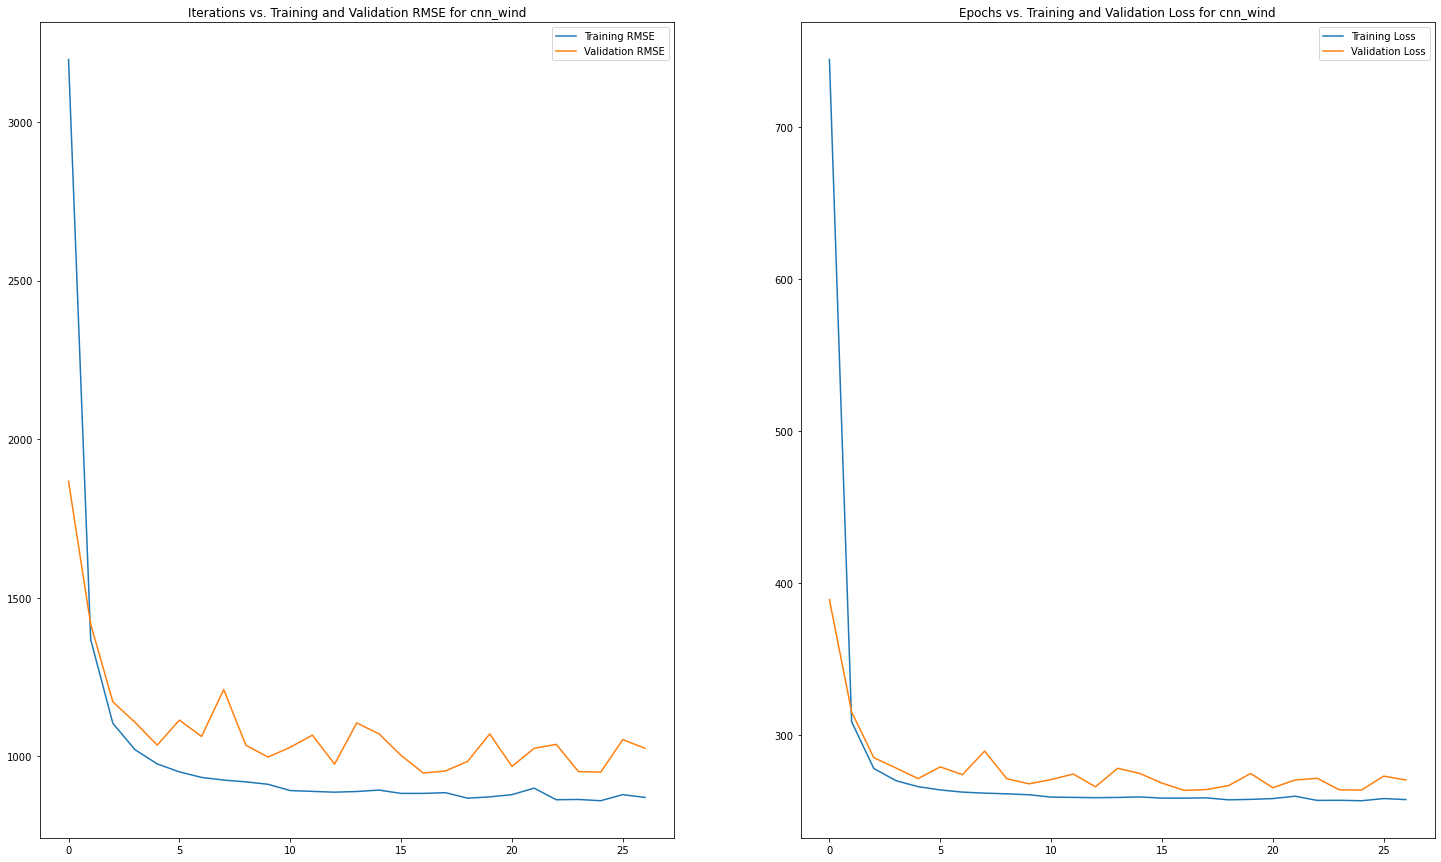

In [13]:
# demo cell
train_end_idx = 17545 # use years 2014-16 for training
cv_end_idx = 26305 # user year 2017 for validation
test_end_idx = 35064 # use year 2018 for testing

df_energy_weather_cnn_preds = df_energy_weather_proc[cv_end_idx+24:test_end_idx]

df_energy_weather_cnn_preds['price_predicted'] = predict_df('price_actual', 'cnn_price')
df_energy_weather_cnn_preds['total_load_predicted'] = predict_df('total_load_actual', 'cnn_load')
df_energy_weather_cnn_preds['gen_solar_totals_predicted'] = predict_df('gen_solar_totals', 'cnn_solar')
df_energy_weather_cnn_preds['gen_wind_totals_predicted'] = predict_df('gen_wind_totals', 'cnn_wind')

## Export the resulting dataset

In [14]:
df_energy_weather_cnn_preds.to_csv('output data/cnn/energy_weather_cnn_preds.csv', index=True)
